In [19]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import *
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
from sklearn.metrics import f1_score 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Image_Train_Data(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
            img_name,label = self.data_list.iloc[item]
        else:
            img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        
        return {
              'gt' : img,
              'label' : torch.tensor(label)
              }

In [4]:
train_path = '/content/drive/My Drive/train_images/train_images'
test_path = '/content/drive/My Drive/test_images/test_images'

In [6]:
batch = 128
train_file = pd.read_csv('/content/drive/My Drive/train.csv')
test_file = pd.read_csv('/content/drive/My Drive/test.csv')
enc = LabelEncoder()
targets = enc.fit_transform(train_file['ClassName'])
print(targets)
train_images = []
test_images = []

[55 41 12 ... 14 12 21]


In [9]:
def aug_transforms(option,test_file,test_path):
    if (option==1):
        transforms_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
        ])
    if (option==2):
        transforms_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5)),
            transforms.ColorJitter(),
            transforms.RandomRotation(10,fill=(0,)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(10,translate=(0.2,0.4))
        ])
    test_data = Image_Train_Data(data_list= test_file,data_dir = test_path,transform = transforms_test)
    
    return test_data

In [10]:
ntrain = train_file
ntrain['ClassName'] = targets

train_data = aug_transforms(2,ntrain,train_path)

Percentage of each class
61 classes from a total of 9323 images


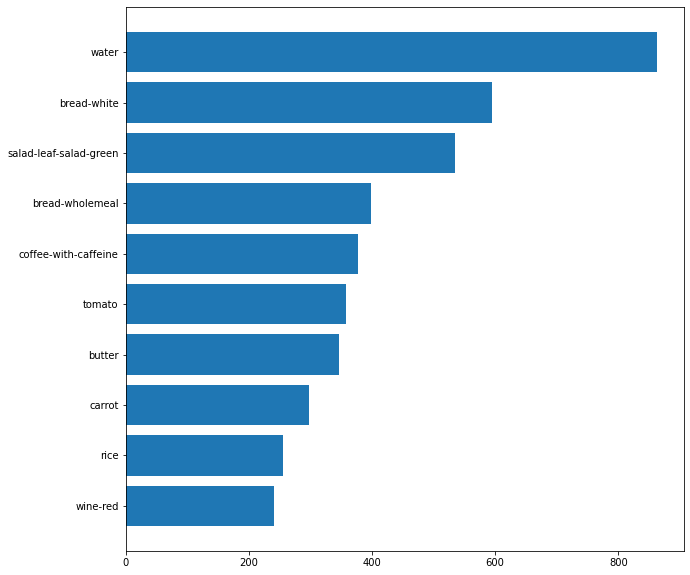

55 	 9.26 %
41 	 1.18 %
12 	 0.9 %
44 	 5.74 %
23 	 2.24 %
13 	 3.71 %
9 	 6.38 %
1 	 2.05 %
22 	 0.94 %
57 	 1.31 %


In [11]:
num = train_file['ClassName'].value_counts()
classes = train_file['ClassName'].unique()
print("Percentage of each class")
print (str(len(classes))+" classes from a total of "+str(train_file.shape[0])+ " images")
num.sort_values()
new_num = num[:10][::-1]
plt.figure(figsize=(10,10))
plt.barh(enc.inverse_transform(new_num.index),new_num.values)
plt.show()

for cl in classes[:10]:
    perc = num[cl]/ntrain.shape[0]*100
    print(cl,'\t',float(round(perc,2)),"%")

In [12]:
valid_size = 0.2
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(valid_size*len(train_data))
train_idx= indices[split:]
valid_idx = indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch, sampler = valid_sampler)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = models.resnet101(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 61)
model.fc = model.fc.cuda() if device else model.fc

model = model.to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [15]:
def process_img_target(images,device):
    data = images['gt'].squeeze(0).to(device)
    target = images['label'].to(device)
    return data,target

In [16]:
n_epochs = 15
train_losses = []
valid_losses = []

def train(model,optimizer,device,valid_loss_min,train_losses,valid_losses):
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_size = len(train_loader.sampler)
        valid_size = len(valid_loader.sampler)

        model.train()
        print ("Training here...\n")
        for images in tqdm(train_loader):
            data = images['gt'].squeeze(0).to(device)
            target = images['label'].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = error(output,target)
            loss.backward()
            optimizer.step()
            loss_shape = data.size(0)
            train_loss += loss.item()*loss_shape 
        
        model.eval()
        print ("Validation here...\n")
        for images in tqdm(valid_loader):
            data,target = process_img_target(images,device)
            output = model(data)
            loss = error(output, target)
            loss_shape = data.size(0)
            valid_loss += loss.item()*loss_shape

        train_loss = train_loss/train_size
        valid_loss = valid_loss/valid_size

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: ',epoch,'\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'best_model_so_far.pth')

train(model,optimizer,device,np.Inf,[],[])

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [10:46<00:00, 43.10s/it]


Epoch:  0 	Training Loss: 3.190586 	Validation Loss: 2.656996


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


Epoch:  1 	Training Loss: 2.406571 	Validation Loss: 2.350254


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:55<00:00,  3.73s/it]


Epoch:  2 	Training Loss: 2.132863 	Validation Loss: 2.168170


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:56<00:00,  3.79s/it]


Epoch:  3 	Training Loss: 1.978860 	Validation Loss: 2.153222


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:56<00:00,  3.75s/it]


Epoch:  4 	Training Loss: 1.917751 	Validation Loss: 2.085803


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:57<00:00,  3.84s/it]


Epoch:  5 	Training Loss: 1.830573 	Validation Loss: 2.073562


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  6 	Training Loss: 1.787362 	Validation Loss: 2.088855
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  7 	Training Loss: 1.755399 	Validation Loss: 2.082725
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch:  8 	Training Loss: 1.721559 	Validation Loss: 2.069877


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  9 	Training Loss: 1.708994 	Validation Loss: 2.085610
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch:  10 	Training Loss: 1.689035 	Validation Loss: 2.049647


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  11 	Training Loss: 1.659530 	Validation Loss: 2.067191
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:55<00:00,  3.71s/it]


Epoch:  12 	Training Loss: 1.653440 	Validation Loss: 2.020243


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:56<00:00,  3.78s/it]


Epoch:  13 	Training Loss: 1.609100 	Validation Loss: 2.014067


  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:56<00:00,  3.77s/it]

Epoch:  14 	Training Loss: 1.597137 	Validation Loss: 2.041017


In [20]:
def test(model):
    model.load_state_dict(torch.load('best_model_so_far.pth'))
    model.eval()
    pred_list = []
    correct_list = []
    with torch.no_grad():
        for images in valid_loader:
            data = images['gt'].squeeze(0).to(device)
            target = images['label'].to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            pr = predicted.detach().cpu().numpy()
            for i in pr:
                pred_list.append(i)
            tg = target.detach().cpu().numpy()
            for i in tg:
                correct_list.append(i)
    
    ans = f1_score(correct_list,pred_list,average='micro')
    return correct_list,pred_list, ans

In [21]:
correct_list, pred_list, ans = test(model)
print("F1 score :",ans)

F1 score : 0.45761802575107297


In [22]:
!pip install aicrowd-cli

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 163kB 7.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 204kB 12.2MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [24]:
class test_Data():
  def __init__(self, root_dir, target_address_file, transform):
    self.root_dir = root_dir
    self.transform = transform
    self.y_label = pd.read_csv(target_address_file)

  def __len__(self):
    return len(self.y_label)

  def __getitem__(self, index):
    img_id = self.y_label.iloc[index,0]
    img = cv2.cvtColor(cv2.imread(os.path.join(self.root_dir, img_id)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    if self.transform is not None:
      img = self.transform(img)
    
    return {
        "image":torch.tensor(img),
        "image_id": img_id
    }

In [25]:
transforms_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
        ])
test_data = test_Data(root_dir = '/content/drive/My Drive/test_images/test_images', target_address_file='/content/drive/My Drive/test.csv', transform = transforms_test)

test_loader2 = DataLoader(dataset = test_data, shuffle=False, batch_size = batch)

In [26]:
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()
imageid = []
pred_list = []

with torch.no_grad():
  for images in test_loader2:
    imageid.extend(images['image_id'])
    pred = model(torch.tensor(images['image']).squeeze(0).to(device))
    _, predicted = torch.max(pred.data, 1)
    pr = predicted.detach().cpu().numpy()
    pr = pr.reshape((pr.shape[0],1))
    for i in range(len(pr)):
      pred_list.append(pr[i][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [27]:
print(pred_list)
print(imageid)

[55, 55, 18, 28, 11, 18, 0, 11, 55, 18, 18, 55, 3, 56, 55, 1, 49, 39, 39, 44, 11, 3, 3, 13, 55, 55, 58, 1, 53, 18, 44, 16, 44, 4, 55, 55, 18, 55, 35, 35, 35, 18, 18, 41, 18, 11, 56, 17, 44, 20, 20, 40, 18, 59, 44, 44, 43, 51, 44, 24, 35, 43, 55, 55, 44, 18, 53, 44, 43, 55, 54, 55, 44, 44, 36, 23, 55, 18, 55, 55, 35, 17, 53, 44, 44, 44, 44, 44, 44, 59, 1, 18, 53, 44, 49, 43, 55, 58, 17, 51, 58, 3, 18, 13, 30, 18, 23, 28, 44, 20, 13, 57, 55, 1, 55, 35, 35, 49, 20, 49, 49, 3, 21, 55, 18, 22, 9, 49, 49, 45, 59, 55, 43, 25, 53, 20, 44, 55, 44, 3, 35, 35, 39, 39, 55, 18, 58, 11, 0, 3, 44, 44, 44, 39, 42, 11, 23, 56, 35, 55, 35, 55, 4, 43, 55, 21, 16, 53, 13, 13, 13, 25, 55, 55, 55, 25, 55, 17, 44, 44, 43, 12, 55, 17, 25, 20, 25, 55, 55, 35, 18, 44, 35, 51, 55, 5, 39, 39, 44, 58, 11, 18, 55, 11, 44, 55, 49, 30, 13, 13, 55, 55, 53, 55, 3, 55, 55, 13, 13, 39, 11, 44, 35, 56, 42, 21, 13, 13, 51, 55, 5, 44, 43, 18, 5, 18, 56, 55, 49, 36, 36, 49, 28, 42, 1, 55, 18, 3, 55, 24, 18, 18, 55, 44, 44, 4

In [28]:
pred_list = enc.inverse_transform(pred_list)
print(pred_list)

['water' 'water' 'coffee-with-caffeine' 'hard-cheese' 'bread-wholemeal'
 'coffee-with-caffeine' 'almonds' 'bread-wholemeal' 'water'
 'coffee-with-caffeine' 'coffee-with-caffeine' 'water' 'banana'
 'water-mineral' 'water' 'apple' 'strawberries' 'pasta-spaghetti'
 'pasta-spaghetti' 'salad-leaf-salad-green' 'bread-wholemeal' 'banana'
 'banana' 'butter' 'water' 'water' 'wine-red' 'apple' 'tomato'
 'coffee-with-caffeine' 'salad-leaf-salad-green' 'chicken'
 'salad-leaf-salad-green' 'beer' 'water' 'water' 'coffee-with-caffeine'
 'water' 'mixed-salad-chopped-without-sauce'
 'mixed-salad-chopped-without-sauce' 'mixed-salad-chopped-without-sauce'
 'coffee-with-caffeine' 'coffee-with-caffeine' 'pizza-margherita-baked'
 'coffee-with-caffeine' 'bread-wholemeal' 'water-mineral'
 'chips-french-fries' 'salad-leaf-salad-green' 'croissant' 'croissant'
 'pickle' 'coffee-with-caffeine' 'wine-white' 'salad-leaf-salad-green'
 'salad-leaf-salad-green' 'rice' 'tea' 'salad-leaf-salad-green'
 'espresso-with-caf

In [30]:
data = pd.DataFrame({"ImageId":imageid,"ClassName":pred_list})

data.to_csv("/content/drive/My Drive/submission2.csv", index = False)

In [31]:
submission = pd.read_csv('/content/drive/My Drive/submission2.csv')

print(submission.head())

          ImageId             ClassName
0  90e63a2fde.jpg                 water
1  a554d1ca8d.jpg                 water
2  48317e8ee8.jpg  coffee-with-caffeine
3  79528df667.jpg           hard-cheese
4  6d2f2f63f5.jpg       bread-wholemeal


In [1]:
!pip install aicrowd-cli

In [2]:
API_KEY = "c3a15f9920d6600174c1d22216f4079f" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [3]:
!aicrowd submission create -c chunin-exams-food-track-cv-2021 -f '/content/drive/My Drive/submission2.csv'

submission2.csv ━━━━━━━━━━━━━━━━━━━━━ 100.0% • 15.7/14.1 KB • 2.8 MB/s • 0:00:00
                                               ╭─────────────────────────╮                                               
                                               │ Successfully submitted! │                                               
                                               ╰─────────────────────────╯                                               
                                                     Important links                                                     
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021/submissions/131028              │
│                  │                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/chunin-ex